In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import importlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch
import pickle
import PIL


# visium stuff
os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code")
print(os.getcwd())
from GNN.code.utils import numpify, select
from GNN.code.DataManager import dataManager
from data import SpatialOmicsSlide, load_training_data, preprocess_wsi
from MaskRCNN import getModel, extractData, ImageDataset, visualize
from MaskRCNN import Constants as C

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code


# Generate Detections

In [4]:
def preprocess(imgs):
    pimgs = []
    for img in imgs:
        pimg = img / 255
        pimg = pimg.transpose(2, 0, 1)
        for i in range(len(pimg)):
            pimg[i] = (pimg[i] - C.means[i]) / C.stds[i]
        pimg = pimg.astype('float32')
        pimgs.append(pimg)
    return pimgs

In [11]:
device = torch.device('cuda')
def generateDetections(model, dm: dataManager, batchsize=10):
    patches = dm.patches
    polygons, classes, X, Y = {}, {}, {}, {}
    for name in dm.snames:
        print(f"Processing Slide: {name}")
        polygons[name], classes[name], X[name], Y[name] = [], [], [], []
        indexes = list(range(len(patches[name])))
        batchIndexes = [indexes[i:i+batchsize] for i in range(0, len(indexes)-batchsize, batchsize)]
        remainder = len(indexes) % batchsize
        batchIndexes.append(indexes[len(patches[name])-remainder-1:])
        for ind in tqdm(batchIndexes):
            imgs = [dm.patches[name][i] for i in ind]
            imgts = [torch.tensor(img).to(device) for img in preprocess(imgs)]
            output = model(imgts)

            # stop overallocating memory
            for imgt in imgts:
                del imgt
            del imgts
            torch.cuda.synchronize()

            for o in output:
                m, c, b, s = extractData(o, debug=False)
                contours, imgpatches, cxs, cys = [], [], [], []
                for i in range(len(m)):
                    mask = m[i].astype(np.uint8)
                    contour, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    contours.append(contour)

                    box = b[i]
                    cx = int(box[0] + (box[2] - box[0]) / 2)
                    cy = int(box[1] + (box[3] - box[1]) / 2)
                    cxs.append(cx)
                    cys.append(cy)

                polygons[name].append(contours)
                classes[name].append(c)
                X[name].append(cxs)
                Y[name].append(cys)

                del o
                torch.cuda.synchronize()

            del output
            torch.cuda.synchronize()
    return polygons, classes, X, Y

In [4]:
# load model
snames = ['A1', 'B1', 'C1', 'D1']
dm = dataManager(snames, load_patches=True, load_detections=False)
maskrcnn = getModel("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/MaskRCNN/models/maskrcnn_resnet50_1_10.pt")
maskrcnn.eval();

Generating Patches...


/dartfs-hpc/rc/home/4/f006m94/anaconda3/envs/arctic/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Fetching Expression...
Loading slide from cache: A1
Loading slide from cache: B1
Loading slide from cache: C1
Loading slide from cache: D1


In [14]:
polygons, classes, X, Y = generateDetections(maskrcnn, dm, batchsize=1)

Processing Slide: A1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2704/2704 [03:55<00:00, 11.46it/s]


Processing Slide: B1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2704/2704 [03:54<00:00, 11.51it/s]


Processing Slide: C1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2704/2704 [03:58<00:00, 11.33it/s]


Processing Slide: D1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2704/2704 [11:54<00:00,  3.79it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


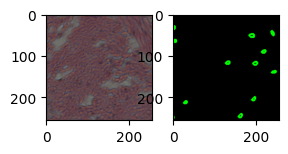

In [19]:
blank = np.zeros((256, 256, 3))
slide = 'B1'; ind = 400
plt.figure(figsize=(3,3))

plt.subplot(1, 2, 1)
plt.imshow(dm.patches[slide][ind])

plt.subplot(1, 2, 2)
# should plot all contours???
for i in range(len(polygons[slide][ind])):
    cv2.drawContours(blank, polygons[slide][ind][i], 0, (0,255,0), 3)
plt.imshow(blank)

In [20]:
# Save things! polygons, classes, boxes, X, Y
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/'
with open(storeDir + 'polygons.pickle', 'wb') as handle:
    pickle.dump(polygons, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(storeDir + 'classes.pickle', 'wb') as handle:
    pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(storeDir + 'xcoords.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(storeDir + 'ycoords.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Train CNN

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
import copy

# import from Code DIR
os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/code")
from graphgen import generateCellPatches, generateCellLabels, neighborFinder
from EmbeddingDataset import EmbeddingDataset, train_val_dataset, connectedComponents

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e9

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels = torch.squeeze(labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [97]:
# MSE on raw counts.
binary = False
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1000)
model.to(device);
# maybe make this ZINB? 
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.00001)

In [14]:
# Binary Cross Entropy Loss.
binary = True
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1000),
    nn.Sigmoid()
)
model.to(device);
criterion = nn.functional.binary_cross_entropy
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

In [4]:
snames = ['A1', 'B1', 'C1', 'D1']
dm = dataManager(snames)

Loading Detections...
Fetching Expression...
Loading slide from cache: A1
Loading slide from cache: B1
Loading slide from cache: C1
Loading slide from cache: D1


In [17]:
snames = ['A1', 'B1', 'C1', 'D1']
cellpatches = generateCellPatches(snames, dm)
celllabels, ind = generateCellLabels(snames, dm)

Average number of visium nodes used per embedding: 0.7643645248730577
Total zero embeddings: 6172
Average number of visium nodes used per embedding: 0.7026858213616489
Total zero embeddings: 7140
Average number of visium nodes used per embedding: 0.725512104283054
Total zero embeddings: 5896
Average number of visium nodes used per embedding: 0.6950401847164869
Total zero embeddings: 6868


In [18]:
# fuse all slides into one dataset.
patches, labels = [], []
fpos = {}
for key in cellpatches:
    patches.extend(select(cellpatches[key], ind[key]))
    if binary:
        labels.extend(select((np.array(celllabels[key] > dm.med_ex[key]))
                              .astype('int'), ind[key]))
    else: 
        labels.extend(select(celllabels[key], ind[key]))
    fpos[key] = select(dm.detxy[key], ind[key])

In [19]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = EmbeddingDataset(patches, labels, image_transform=transform, target_transform=transform)
datasets = train_val_dataset(dataset, fpos, 50)
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=64, \
                shuffle=True, num_workers=4) for x in ['train', 'val']}

Valid Shuffle: True


In [107]:
print(len(dataloaders['train']))
print(len(dataloaders['val']))

721
81


In [22]:
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/cnn_models'
model = train_model(model, criterion, optim, num_epochs=3)

with open(f'{storeDir}/modelkey.txt', "r") as f:
    modelkey = int(str(f.read()))
    torch.save(model.state_dict(), f"{storeDir}/v{modelkey}.pt")

with open(f'{storeDir}/modelkey.txt', "w") as f:
    f.write(str(modelkey+1))

Epoch 0/2
----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 934/934 [00:30<00:00, 30.45it/s]


train Loss: 0.3378


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:02<00:00, 55.64it/s]


val Loss: 0.3942

Epoch 1/2
----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 934/934 [00:33<00:00, 27.77it/s]


train Loss: 0.3345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:03<00:00, 33.44it/s]


val Loss: 0.4019

Epoch 2/2
----------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 934/934 [00:28<00:00, 32.65it/s]


train Loss: 0.3307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:03<00:00, 35.28it/s]


val Loss: 0.3988

Training complete in 1m 43s


In [75]:
# Load model from save.
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/cnn_models'
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1000)
"""
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1000),
    nn.Sigmoid()
)
"""
model.cuda()

modelkey=8
# state_dict = torch.load(f"{storeDir}/v{modelkey}.pt", map_location=device)
state_dict = torch.load(f"{storeDir}/embeddingsV1.pt", map_location='cuda')
model.load_state_dict(state_dict)
model.eval();

In [23]:
import matplotlib
# import from Code DIR
os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/code")
from visualize import plotHeatmaps, plotAUROC

In [78]:
def fetchPatchTensor(patch):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(patch)

In [79]:
slides = ['A1', 'B1', 'C1', 'D1']
celllabels, ind = generateCellLabels(slides, dm)
cellpatches = generateCellPatches(slides, dm)
transform = transforms.Compose([transforms.ToTensor()])
dataloaders = {}
for name in slides:
    dataset = EmbeddingDataset(cellpatches[name], celllabels[name], image_transform=fetchPatchTensor, target_transform=transform)
    dataloaders[name] = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

Average number of visium nodes used per embedding: 0.7643645248730577
Total zero embeddings: 6172
Average number of visium nodes used per embedding: 0.7026858213616489
Total zero embeddings: 7140
Average number of visium nodes used per embedding: 0.725512104283054
Total zero embeddings: 5896
Average number of visium nodes used per embedding: 0.6950401847164869
Total zero embeddings: 6868


/dartfs-hpc/rc/home/4/f006m94/anaconda3/envs/arctic/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [80]:
# TODO: save labels for all genes in one place.
# We need to map our saved labels back to their original locations.
# Don't shuffle, read in all data, match it up with all cell detections.
preds = {}
for name in dm.snames:
    preds[name] = []
    for inputs, labels in tqdm(dataloaders[name]):
        inputs = inputs.to(device)
        # inputs = torch.stack([fetchPatchTensor(el) for el in inputs]).to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()
        with torch.no_grad():
            logits = model(inputs)
        for pred in numpify(logits):
            preds[name].append(pred)
    preds[name] = np.array(preds[name])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [01:28<00:00,  3.96it/s]


In [12]:
slide = 'B1';
image = np.array(PIL.Image.open(dm.datadir + '/raw_data/' + slide + '.TIF'))

In [13]:
print(image.shape)

(13323, 13419, 3)


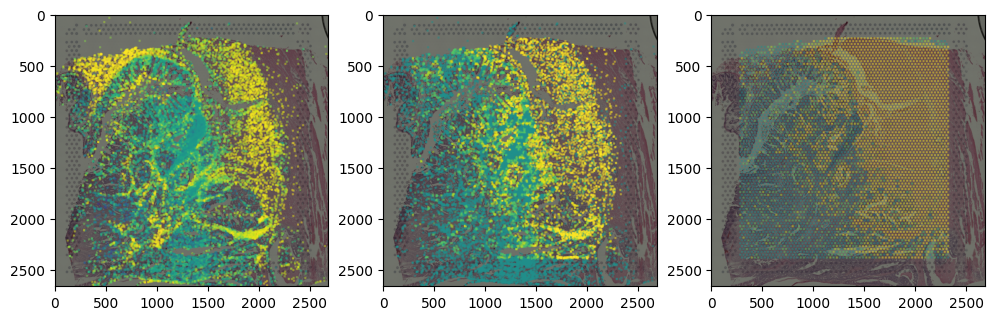

In [19]:
gene_index = 5;
labels = np.squeeze(np.array(celllabels[slide]))

fig, axs = plt.subplots(1, 3)
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex[slide]), dm.nodexy[slide])

axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_gt)
axs[2].imshow(heatmap_nodes)

# Validate CNN

In [ ]:
#plt.rcParams['figure.figsize'] = [12, 8]
#flabels = {key: select(celllabels[key], ind[key]) for key in celllabels}
#fpreds = {key: select(preds[key], ind[key]) for key in preds}
#plotAUROC(dm.snames, flabels, fpreds, dm.med_ex)

flabels = {key: np.array(select(celllabels[key], ind[key])) for key in dm.snames}
fpreds = {key: np.array(select(preds[key], ind[key])) for key in preds}
plotAUROC(dm.snames, flabels, fpreds, dm.med_ex)
#plotAP(dm.snames, flabels, fpreds, dm.med_ex, binary=True)

[[1 1 0 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 ...
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]]
Median AUROC - 0.5
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 1 0]
 [0 1 0 ... 1 1 1]
 [0 1 0 ... 1 1 0]] [[1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 ...
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]]


In [81]:
# Calculate Embeddings!!!
# embed_model = torch.nn.Sequential(*(list(model.children())[:-1]))
embed_model = model

In [82]:
slides = ['A1', 'B1', 'C1', 'D1']
celllabels, ind = generateCellLabels(slides, dm)
cellpatches = generateCellPatches(slides, dm)
transform = transforms.Compose([transforms.ToTensor()])
dataloaders = {}
for name in slides:
    dataset = EmbeddingDataset(cellpatches[name], celllabels[name], image_transform=transform, target_transform=transform)
    dataloaders[name] = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

Average number of visium nodes used per embedding: 0.7643645248730577
Total zero embeddings: 6172
Average number of visium nodes used per embedding: 0.7026858213616489
Total zero embeddings: 7140
Average number of visium nodes used per embedding: 0.725512104283054
Total zero embeddings: 5896
Average number of visium nodes used per embedding: 0.6950401847164869
Total zero embeddings: 6868


In [83]:
device = 'cuda'
embeddings = {}
for name in dm.snames:
    embeddings[name] = []
    for inputs, labels in tqdm(dataloaders[name]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()
        with torch.no_grad():
            logits = embed_model(inputs)
        for pred in numpify(logits):
            embeddings[name].append(pred)
    embeddings[name] = np.array(embeddings[name])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:29<00:00, 11.75it/s]


In [42]:
print(embeddings['A1'][0])

[ 2.25678110e+00 -4.79955405e-01 -6.62873149e-01  2.30033219e-01
 -9.32560921e-01 -1.13081074e+00 -2.16766477e-01  4.10521090e-01
  3.15246701e-01  5.40250838e-02  1.86015415e+00 -7.58416116e-01
 -9.50717747e-01  2.45556736e+00  1.38581371e+00  2.11405724e-01
  9.07454967e-01 -8.00827563e-01  1.09718120e+00 -2.06002760e+00
  2.42316151e+00 -4.53551024e-01  9.36056316e-01 -1.04726577e+00
 -3.17631625e-02 -6.90412641e-01  7.35974908e-01 -2.23976898e+00
 -8.47927108e-03  3.18286633e+00  4.49779063e-01  6.92434072e-01
 -5.82760572e-01 -2.21344137e+00 -4.38014477e-01 -9.01443362e-01
 -3.38155299e-01  5.09549558e-01 -2.94445539e+00  7.78926373e-01
 -6.35822490e-02 -2.81870866e+00  1.27027678e+00 -1.44534683e+00
 -4.59911227e-01 -5.30900478e-01 -2.96639770e-01  1.43581235e+00
 -5.11956096e-01 -2.02251539e-01  5.47006726e-02 -3.28287721e-01
  2.24140716e+00 -8.45957339e-01  1.03289258e+00  2.31267118e+00
 -1.37282741e+00  1.45298731e+00  7.34563917e-03  5.11833668e-01
  3.14424276e-01  4.33499

In [84]:
# Save cnn embeddings
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/'
with open(storeDir + 'cnn_embed.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Generate Feature Vectors

In [85]:
# Load cnn embeddings
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/'
with open(storeDir + 'cnn_embed.pickle', 'rb') as handle:
    cnn_embeddings = pickle.load(handle)

In [86]:
# TODO: save feature vectors to avoid recomputation!
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store'
for name in dm.snames:
    nx = [x for x,y in dm.detxy[name]]
    ny = [y for x,y in dm.detxy[name]]
    d = {'X' : nx, 'Y' : ny, 'Embedding' : list(np.squeeze(cnn_embeddings[name]))}
    df = pd.DataFrame(data=d)
    pickle.dump(df, open(f'{storeDir}/nodes/{name}.pickle', "wb"))

# Graph Stuff

In [87]:
import torch
import os 
import sys
import numpy as np
import glob, pandas as pd
import pickle
import torch_geometric
import scipy.sparse as sps
from sklearn.preprocessing import LabelEncoder
from torch_cluster import knn_graph
import torch_geometric
from torch_geometric.data import Data 
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset,DataLoader
from torch_cluster import radius_graph
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split

os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/code")
from graphgen import neighborFinder

In [17]:
# for inspecting positions.
df = pickle.load(open(os.path.join(storeDir,f"nodes/A1.pickle"), "rb"))
inv = np.stack([[] == x for x in df.Embedding.values])
emb = df.Embedding.values
pos = df[['X','Y']].values
for p in pos:
    pass

/scratch/ipykernel_70223/3871699511.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  inv = np.stack([[] == x for x in df.Embedding.values])


In [88]:
# Graph pooling and then check with neighbors???
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store'
def get_graph_dataset(basename, data, embedding_dir=f'{storeDir}/nodes', \
                      noderad=150, graphrad=100, binary=False):
    df = pickle.load(open(os.path.join(embedding_dir,f"{basename}.pickle"), "rb"))
    emb = df.Embedding.values
    pos = df[['X','Y']].values
    
    # make a graph for each visium node.
    datasets = []
    avg = 0
    n = neighborFinder(data.detxy[basename], tile_factor=100)
    for ind in tqdm(range(len(data.nodexy[basename]))):
        spos, semb = [], []
        neighbors = n.find(data.nodexy[basename][ind], noderad)
        for index in neighbors:
            spos.append(pos[index])
            semb.append(emb[index])
        
        if (len(semb) == 0 or len(spos) == 0): continue;
        avg += len(spos)
        semb = torch.tensor(np.stack([x for x in semb]), dtype=torch.float32)
        spos = torch.tensor(np.array(spos), dtype=torch.float32).cuda()
        sgraph = radius_graph(spos, r=graphrad, batch=None, loop=True)
        sgraph = sgraph.detach().cpu()
        sgraph = torch_geometric.utils.add_remaining_self_loops(sgraph)[0]
        if (binary):
            slbl = torch.tensor(data.gene_ex_binary[basename][ind], dtype=torch.float32)
        else:
            slbl = torch.tensor(data.gene_ex[basename][ind], dtype=torch.float32)
        dataset = Data(x=semb, edge_index=sgraph, edge_attr=None, y=slbl, pos=spos, global_id=ind)
        datasets.append(dataset)
    print("Average Graph Size: ", avg / len(datasets))
    return datasets

In [ ]:
dm = dataManager(['A1'])

In [89]:
datasets = {}
for name in dm.snames:
    datasets[name] = get_graph_dataset(name, dm, binary=True)
    print("Number of Graphs: ", len(datasets[name]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:04<00:00, 1063.20it/s]


Average Graph Size:  16.817283431455003
Number of Graphs:  4756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4922/4922 [00:03<00:00, 1468.38it/s]


Average Graph Size:  14.63923361637274
Number of Graphs:  4593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4887/4887 [00:03<00:00, 1466.55it/s]


Average Graph Size:  12.943474646716542
Number of Graphs:  4812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4169/4169 [00:03<00:00, 1173.15it/s]


Average Graph Size:  16.504223864836327
Number of Graphs:  3788


In [154]:
index = 6
print(datasets['B1'][index])
print(numpify(datasets['B1'][index].pos))
print(numpify(datasets['B1'][index].edge_index))

Data(x=[5, 512], edge_index=[2, 12], edge_attr=[12, 1], y=[1000], pos=[5, 2], global_id=11)
[[6013. 1349.]
 [6083. 1130.]
 [6091. 1142.]
 [6108. 1363.]
 [5925. 1194.]]
[[3 2 1 0 0 1 2 3 0 1 2 3]
 [0 1 2 3 0 1 2 3 4 4 4 4]]


In [90]:
# Save graphs.
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/'
with open(storeDir + 'graphs.pickle', 'wb') as handle:
    pickle.dump(datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
import sys, os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import os,glob, pandas as pd
from sklearn.metrics import f1_score
import copy
from collections import Counter
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv, GATConv, DeepGraphInfomax, SAGEConv, ClusterGCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj, dense_to_sparse
from torch_geometric.nn import GINEConv
from torch_geometric.utils import dropout_adj
from torch_geometric.nn import APPNP
from torch_cluster import knn_graph
from torch_geometric.data import Data 
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
# for use in validation.
from sklearn.metrics import average_precision_score, roc_auc_score

In [92]:
EPS = 1e-15

class GCNNet(torch.nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_topology=[32,64,128, 128]):
        super(GCNNet, self).__init__()
        self.out_dim=out_dim
        self.convs = nn.ModuleList([GATConv(inp_dim, hidden_topology[0])] \
                                   + [GATConv(hidden_topology[i],hidden_topology[i+1]) \
                                     for i in range(len(hidden_topology[:-1]))])
        self.fc = nn.Linear(hidden_topology[-1], out_dim)
        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.fc(x)
        x = global_mean_pool(x, batch)
        return x
    
    def infer(self, x, edge_index, batch):
        x = self.forward(x, edge_index, batch)
        x = self.sigmoid(x)
        return x

In [93]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def fit_model(graphs,
                use_model=None,
                n_batches_backward=1,
                n_epochs=1500,
                lr=1e-2,
                eta_min=1e-4,
                T_max=20,
                wd=0,
                hidden_topology=[32,64,128],
                gpu_id=0,
                batch_size=1,
                storeDir='/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/gnn_models'
                ):
    print(gpu_id); torch.cuda.set_device(gpu_id)

    train_dataset = []
    for name in ['B1', 'C1', 'D1']:
        train_dataset.extend(graphs[name])
        
    val_dataset = []
    for name in ['A1']:
        val_dataset.extend(graphs[name])
    
    # Readout
    print(len(train_dataset), " training graphs, ", len(val_dataset), " validation graphs")
    
    print(f"In Dim: {len(train_dataset[0].x[0])}, Out Dim: {len(train_dataset[0].y)}")
    model = GCNNet(len(train_dataset[0].x[0]), len(train_dataset[0].y))
    if use_model:
        model.load_state_dict(torch.load(use_model))
    model=model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())

    optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=eta_min, last_epoch=-1)
    criterion = nn.functional.binary_cross_entropy_with_logits

    # dataloaders
    dataloaders={}
    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print(len(dataloaders['train']), len(dataloaders['val']))

    n_total_batches=0
    train_val_loss = []
    best_loss = 1e9
    for epoch in range(n_epochs):
        trainloss = 0
        for i, data in enumerate(dataloaders['train']):
            n_total_batches += 1
            model.train(True)
            x = data.x.to(device)
            edge_index = data.edge_index.to(device)
            y = data.y.to(device)
            batch = data.batch.to(device)
            y_out = torch.flatten(model(x, edge_index, batch))
            loss = criterion(y_out, y, weight=torch.tensor([1]).cuda()) / n_batches_backward
            loss.backward()
            trainloss += loss.item()
            if (n_total_batches % n_batches_backward == 0):
                optimizer.step()
                optimizer.zero_grad()
            del x, edge_index, loss, y_out, batch
        trainloss /= len(dataloaders['train'])
        scheduler.step()
                    
        valloss = 0
        for i, data in enumerate(dataloaders['val']):
            model.train(False)
            x = data.x.to(device)
            edge_index = data.edge_index.to(device)
            y = data.y.to(device)
            batch = data.batch.to(device)
            y_out = torch.flatten(model(x, edge_index, batch))
            loss = criterion(y_out, y, weight=torch.tensor([1]).cuda()) 
            valloss += lo\\\ss.item()
            del x, edge_index, loss, y_out, batch
        valloss /= len(dataloaders['val'])
        
        if valloss < best_loss:
            best_loss = valloss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        if (epoch % 50 == 0 and epoch != 0):
            with open(f'{storeDir}/modelkey.txt', "r+") as f:
                modelkey = int(str(f.read()))
                torch.save(best_model_wts, f"{storeDir}/GATv{modelkey}_{epoch}.pth")
        
        print(f"Epoch: {epoch} | Training Loss: {trainloss} | Validation Loss: {valloss}", flush=True)
        train_val_loss.append((trainloss, valloss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [94]:
Dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store'
graphs = pickle.load(open(f"{Dir}/graphs.pickle", "rb"))

In [95]:
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/gnn_models'
gnn_model = fit_model(graphs, lr=1e-3, n_epochs=5, gpu_id=0, batch_size=256, storeDir=storeDir)

with open(f'{storeDir}/modelkey.txt', "r+") as f:
    modelkey = int(str(f.read()))
    torch.save(gnn_model.state_dict(), f"{storeDir}/GATv{modelkey}.pth")
    
with open(f'{storeDir}/modelkey.txt', "w") as f:
    f.write(str(modelkey+1))

0
13193  training graphs,  4756  validation graphs
In Dim: 1000, Out Dim: 1000
52 19
Epoch: 0 | Training Loss: 0.5846258344558569 | Validation Loss: 0.6103733872112475
Epoch: 1 | Training Loss: 0.524235493861712 | Validation Loss: 0.5741155994565863
Epoch: 2 | Training Loss: 0.511171814913933 | Validation Loss: 0.5907557042021501
Epoch: 3 | Training Loss: 0.5095292788285476 | Validation Loss: 0.5754410530391493
Epoch: 4 | Training Loss: 0.508495800770246 | Validation Loss: 0.5796194390246743


# Validate GNN

In [1]:
Dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/gnn_models'
gnn_model = GCNNet(512, 1000)
modelkey = 5
#state_dict = torch.load(f"{Dir}/GATv{modelkey}.pth", map_location=device)
state_dict = torch.load(f"{Dir}/GATv9_100.pth", map_location=device)
gnn_model.load_state_dict(state_dict)
gnn_model.eval();
gnn_model.to(device);

NameError: name 'GCNNet' is not defined

In [47]:
# Run model on all graphs to obtain all predictions.
graph_data = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/graphs.pickle'
graphs = pickle.load(open(graph_data, "rb"))

In [102]:
print([key for key in graphs])
#print(data['B1'])

['A1', 'B1', 'C1', 'D1']


In [96]:
gnn_model.eval();
preds = {}
valid = {}
for name in graphs:
    preds[name] = []
    valid[name] = []
    dataloader = DataLoader(graphs[name], batch_size=256)
    for i, data in tqdm(enumerate(dataloader)):
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        y = data.y.to(device)
        batch = data.batch.to(device)
        batch_preds = gnn_model.infer(x,edge_index,batch)
        ids = numpify(data.global_id)
        for i, pred in enumerate(numpify(batch_preds)):
            preds[name].append(pred)
            valid[name].append(ids[i].item())
        del x, edge_index, y, batch_preds, batch
    valid[name] = np.array(valid[name])

19it [00:05,  3.20it/s]
18it [00:00, 37.36it/s]
19it [00:00, 38.40it/s]
15it [00:00, 33.64it/s]


Median AUROC - 0.7311255120349984
Median AUROC - 0.7294528798518221
Median AUROC - 0.6255819243026592
Median AUROC - 0.7607198797845319
Median AP - 0.6444463897581121
Median AP - 0.6280627492917062
Median AP - 0.4365319316123898
Median AP - 0.3349570665834052


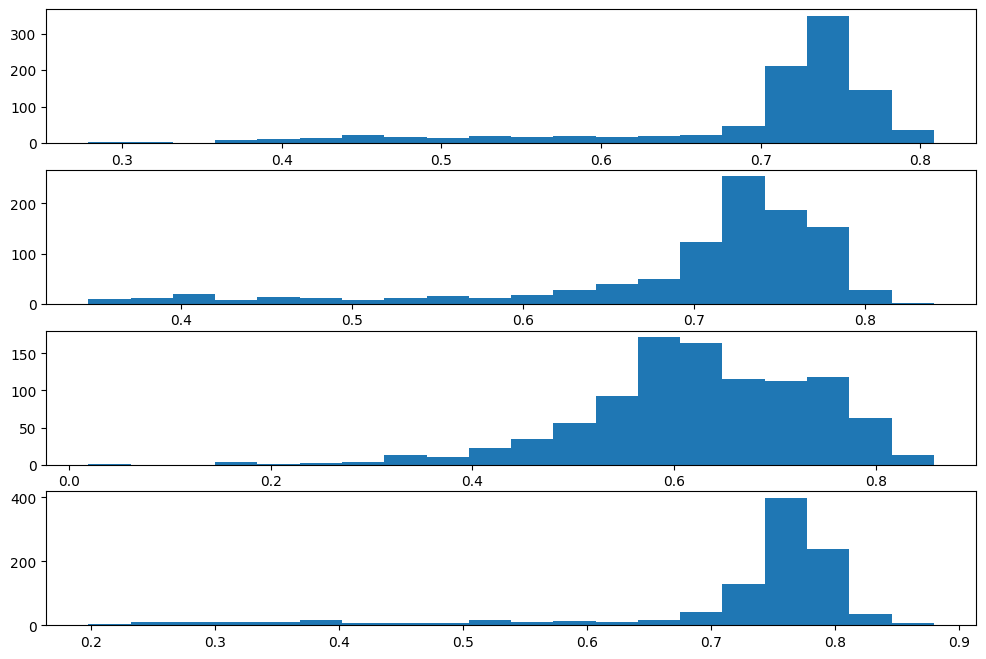

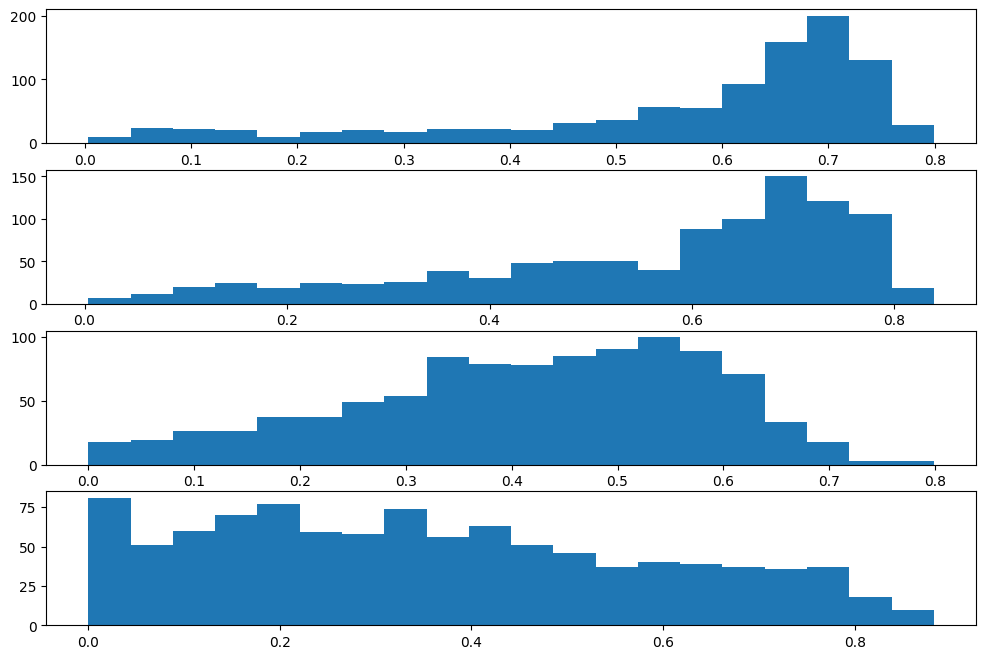

In [97]:
os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/code")
from visualize import plotHeatmaps, plotAUROC, plotAP
plt.rcParams['figure.figsize'] = [12, 8]
# B held out.
flabels = {key: np.array(select(dm.gene_ex_binary[key], valid[key])) for key in dm.snames}
fpreds = {key: np.array(preds[key]) for key in preds}
plotAUROC(dm.snames, flabels, fpreds, dm.med_ex, binary=True)
plotAP(dm.snames, flabels, fpreds, dm.med_ex, binary=True)

In [27]:
slide = 'B1';
image = np.array(PIL.Image.open(dm.datadir + '/raw_data/' + slide + '.TIF'))

/dartfs-hpc/rc/home/4/f006m94/anaconda3/envs/arctic/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


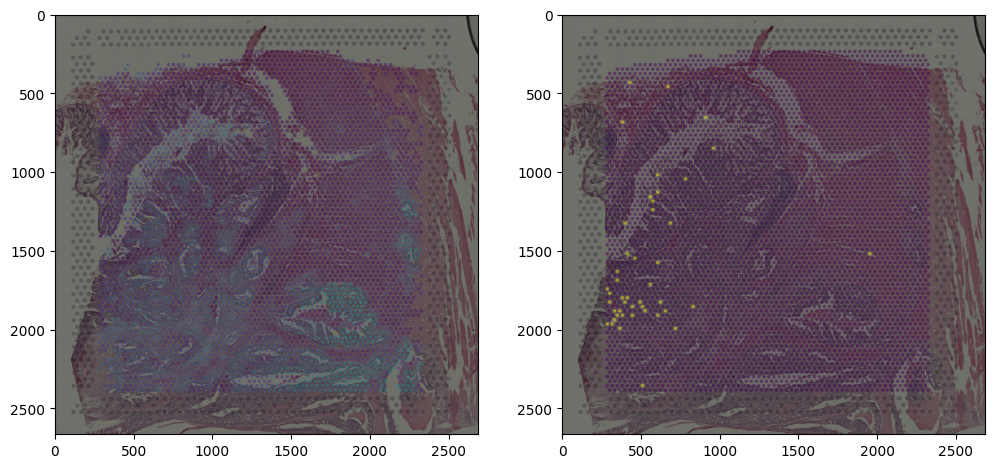

In [41]:
gene_index = 27;

fig, axs = plt.subplots(1, 2)
# filter positions to ones predicted on.
pos = np.array([dm.nodexy[slide][i] for i in valid[slide]])
heatmap_imp = plotHeatmaps(image, gene_index, np.array(preds[slide]), pos, binary=True)
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex_binary[slide], dtype=np.float32), dm.nodexy[slide], binary=True)
axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_nodes)